**Autores**: 
1. Caio Fernandes - 170138798
2. Lucas Dutras - 170050939

Este projeto tem como objetivo utilizar `jupyter notebook` e a biblioteca `pandas` juntamente com o conteúdo de **Percorrer Grafos** para indicar qual o caminho mais rápido para chegar em um país a partir de um país inicial.

Utilizaremos para isso dois datasets disponibilizados no Kaggle com informações sobre [Países e Fronteiras](https://www.kaggle.com/resheto/country-borders) e [Países e Continentes](https://www.kaggle.com/tomvebrcz/countriesandcontinents).

In [1]:
import pandas as pd
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import nx_animation

In [2]:
df_border = pd.read_csv('./data/border_info.csv')
df_continents = pd.read_csv('./data/countries.csv')
df_border = df_border.sort_values(by=['country_name'])
df_continents = df_continents.sort_values(by=['Country'])

## Avaliação do Dado

In [3]:
df_border.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 728 entries, 9 to 727
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           728 non-null    int64 
 1   country_name         728 non-null    object
 2   country_border_name  642 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.8+ KB


## Limpando o dado 

Removendo países sem fronteira

In [4]:
is_NaN = df_border.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_border[row_has_NaN]
rows_with_NaN

,Unnamed: 0,country_name,country_border_name
41,41,Aland Islands,NaN
30,30,American Samoa,NaN
11,11,Anguilla,NaN
24,24,Antarctica,NaN
10,10,Antigua and Barbuda,NaN
...,...,...,...
684,684,United States Minor Outlying Islands,NaN
704,704,Vanuatu,NaN
699,699,Virgin Islands (British),NaN
700,700,Virgin Islands (U.S.),NaN


Temos 86 países sem fronteiras no dado

Removendo-os:

In [5]:
df_border = df_border.drop(rows_with_NaN.index)

Notamos que, neste dado em questão, temos 727 valores.
Tal dado também apresenta duas colunas, uma `country_name` representando o país e outra chamada `coutry_border_name` que representa um fronteira daquele país.

In [6]:
df_border.head()

,Unnamed: 0,country_name,country_border_name
9,9,Afghanistan,Uzbekistan
4,4,Afghanistan,China
5,5,Afghanistan,Iran
6,6,Afghanistan,Pakistan
7,7,Afghanistan,Tajikistan


Logo percebemos um problema, a maneira como o dado está organizado, nos trás informações duplicadas sobre países.
Para corrigir este problema, faremos, para cada país, uma coluna com uma lista de todas as fronteiras.
Com isso, teremos na estrutura do `DataFrame`, países únicos na coluna `country_name` com suas fronteiras listada na coluna `border_list`.

In [7]:
k = df_border.groupby('country_name')['country_border_name'].apply(lambda x: list(x))
df_border = df_border.drop(columns=['country_border_name'])
df_border = df_border.drop_duplicates(subset=['country_name'])
aux = [item for item in k]
df_border['border_list'] = aux

Após transformarmos o dado inicial em menos linhas, é necessária a reindexação do dataframe.

In [8]:
df_border = df_border.reset_index()
df_border = df_border.drop(columns=['Unnamed: 0', 'index'])

## Cruzando as duas fontes de dados

Agora, iremos cruzar os dados do dataset de fronteiras juntamente com o dataset de continentes, para, posteriormente, montarmos vários grafos, sendo cada um deles representante de um continente.

In [9]:
df_continents['Region'] = df_continents['Region'].replace('LATIN', 'AMERICA')
df_continents['Region'] = df_continents['Region'].replace('NORTHERN_AMERICA', 'AMERICA')
df_continents['Region'] = df_continents['Region'].replace('NEAR_EAST', 'ASIA')
border_l = df_border['country_name'].tolist()
cont_l = df_continents['Country'].tolist()
diff = []
for item in cont_l:
    if item in border_l:
        continent = df_continents.loc[df_continents['Country'] == item]
        continent = continent['Region']
        for elem in continent.iteritems():
            df_border.loc[df_border['country_name'] == item, 'continent'] = elem[1]

Porém, como os dados provém de fontes diferentes e existe a possibilidade de haver nomeações diferentes para cada país, logo um conjunto de dados ficará sem a devida informação de continente.

In [10]:
is_NaN = df_border.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_border[row_has_NaN]
rows_with_NaN

,country_name,border_list,continent
16,Bosnia and Herzegovina,"[Croatia, Serbia, Montenegro]",NaN
26,Central African Republic,"[Cameroon, Chad, Congo (Kinshasa), Congo (the ...",NaN
31,Congo (Kinshasa),"[Cameroon, Central African Republic, Congo (th...",NaN
32,Congo (the Democratic Republic of the),"[Burundi, Angola, Tanzania, Rwanda, South Suda...",NaN
34,Cote d'Ivoire,"[Burkina Faso, Ghana, Guinea, Liberia, Mali]",NaN
36,Czechia,"[Austria, Germany, Poland, Slovakia]",NaN
46,Eswatini,"[Mozambique, South Africa]",NaN
63,Holy See,[Italy],NaN
77,Korea (Democratic People's Republic of),"[Russia, Korea, South, China]",NaN
78,"Korea, South",[Korea (Democratic People's Republic of)],NaN


Identificando os países que não estavam presentes com a mesma notação, agrupamos em grupos por continente e foi feita a atribuição devida para cada um dos sobressalentes.

In [11]:
eu = ['Bosnia and Herzegovina', 'Czechia', 'Holy See', 'Montenegro', 'North Macedonia']
asia = ['Korea (Democratic People\'s Republic of)', 'Korea, South', 'Macao', 'Myanmar', 'Palestine, State of', 'Timor-Leste']
america = ['Saint Martin (French part)', 'Sint Maarten (Dutch part)', 'US']
africa = ['Central African Republic', 'Congo (Kinshasa)', 'Congo (the Democratic Republic of the)', 'Cote d\'Ivoire', 'Eswatini', 'South Africa', 'South Sudan']
for country in eu:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'EUROPE'
for country in asia:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'ASIA'
for country in america:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'AMERICA'
for country in africa:
    df_border.loc[df_border['country_name'] == country, 'continent'] = 'AFRICA'

In [12]:
df_continents['Region'].value_counts()

AFRICA     57
EUROPE     50
AMERICA    50
ASIA       49
OCEANIA    21
Name: Region, dtype: int64

# Implementando Lista de Adjacência para formar a rede de Grafo

In [13]:
graph = defaultdict(list)
for item in df_border.country_name.unique():
    graph[item] = df_border.border_list[df_border.country_name==item].item()

# Aplicando busca em largura - Breadth First Search (BFS)

In [14]:
visited = defaultdict()
def backtrace(parent, start, end):
    path = [end]
    while path[-1] != start:
        path.append(parent[path[-1]])
    path.reverse()
    return path

def bfs(graph, start, end):
    parent = {}
    queue = []
    visited[start] = True
    queue.append(start)
    while queue:
        node = queue.pop(0)
        if node == end:
            return backtrace(parent, start, end)
        for adjacent in graph.get(node, []):
                if adjacent not in visited.keys():
                    if node not in queue :
                        parent[adjacent] = node # <<<<< record its parent 
                        queue.append(adjacent)
                        visited[adjacent] = True

country_path = bfs(graph, 'Colombia', 'US')

## Visualização da árvore resultante da busca em largura

In [15]:
resultant_tree = nx.Graph()
i, j = 0, 1
while j < len(country_path):
    resultant_tree.add_edge(country_path[i], country_path[j])
    i += 1
    j += 1

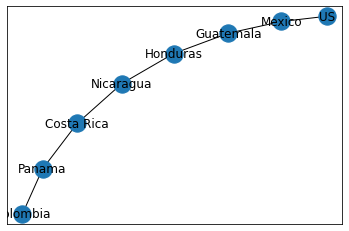

In [16]:
nx.draw_networkx(resultant_tree) 

# Visualizando o grafo completo

In [17]:
cities_graph = nx.Graph()

cities_graph.add_nodes_from(list(graph.keys()))

for city in list(graph.keys()):
    for frontier in graph[city]:
        cities_graph.add_edge(city,frontier)

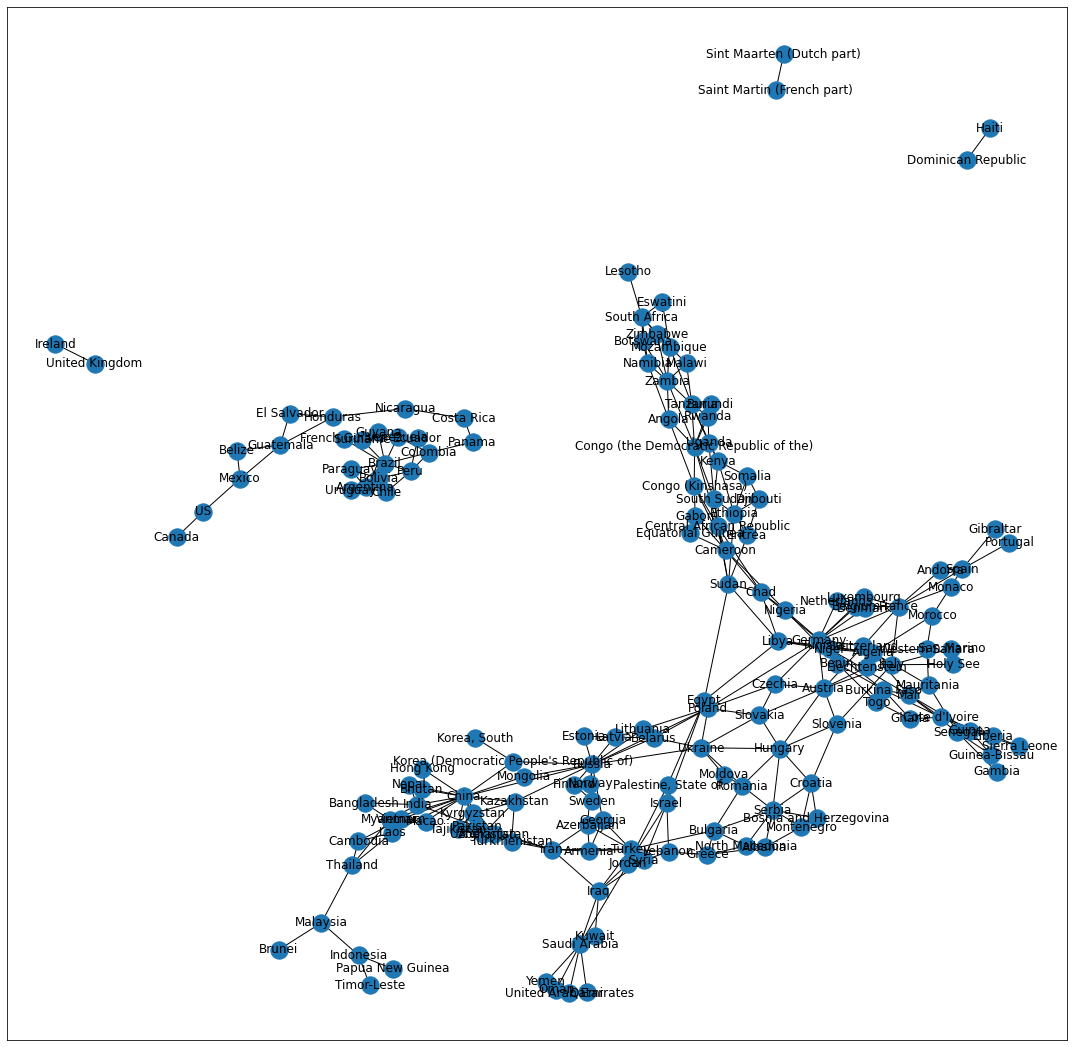

In [18]:
plt.figure(3,figsize=(19,19))
nx.draw_networkx(cities_graph)
# camroll(-180)  
# plt.gca().invert_yaxis()
plt.show()

### Opções de plot

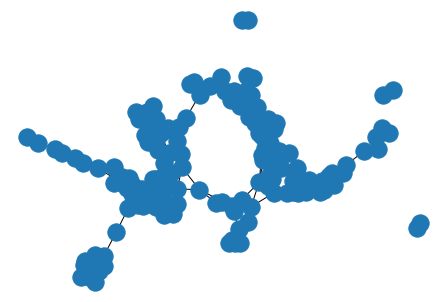

In [19]:
nx.draw(cities_graph)  
# nx.draw_circular(cities_graph)
# nx.draw_spectral(cities_graph)
# nx.draw_spring(cities_graph)

/Users/caiofernandes/Desktop/Projetos/PAA/Grafos1_Cities/grafos1_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 5 + 1) instead
  from ipykernel import kernelapp as app
MovieWriter imagemagick unavailable; using Pillow instead.


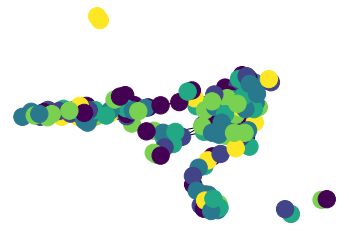

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation

# number of nodes
size = len(cities_graph)

# generate graph
G=cities_graph

# generating input frames here, since my data is too big
# its important that the frames go as input and is not generated
# on the fly
frame = np.random.random_integers(0, 5, (size, size)) # random ndarray between 0 and 5, length and number of frames = number of nodes in the graph

# draw the topology of the graph, what changes during animation
# is just the color
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G,pos)
edges = nx.draw_networkx_edges(G,pos)
plt.axis('off')

# pass frames to funcanimation via update function
# this is where I get stuck, since I cannot break
# out of the loop, neither can I read every array of
# the ndarray without looping over it explicitly
def update(i):
    # for i in range(len(frame)):
    # instead of giving frame as input, if I randomly generate it, then it works
    nc = frame[i] # np.random.randint(2, size=200)
    nodes.set_array(nc)
    return nodes,

# output animation; its important I save it
fig = plt.gcf()
ani = FuncAnimation(fig, update, interval=50, frames=range(size), blit=True)
ani.save('crap.gif', writer='imagemagick',  savefig_kwargs={'facecolor':'white'}, fps=1)

In [23]:
from IPython.display import HTML
k = HTML('<img src="./crap.gif">')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
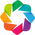

In [30]:
import numpy as np
import pandas as pd
import holoviews as hv
import networkx as nx
from holoviews import opts

hv.extension('bokeh')

defaults = dict(width=800, height=800)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))

In [27]:
# plt.figure(3,figsize=(13,13))
hv.Graph.from_networkx(cities_graph, nx.layout.spring_layout)

:Graph   [start,end]

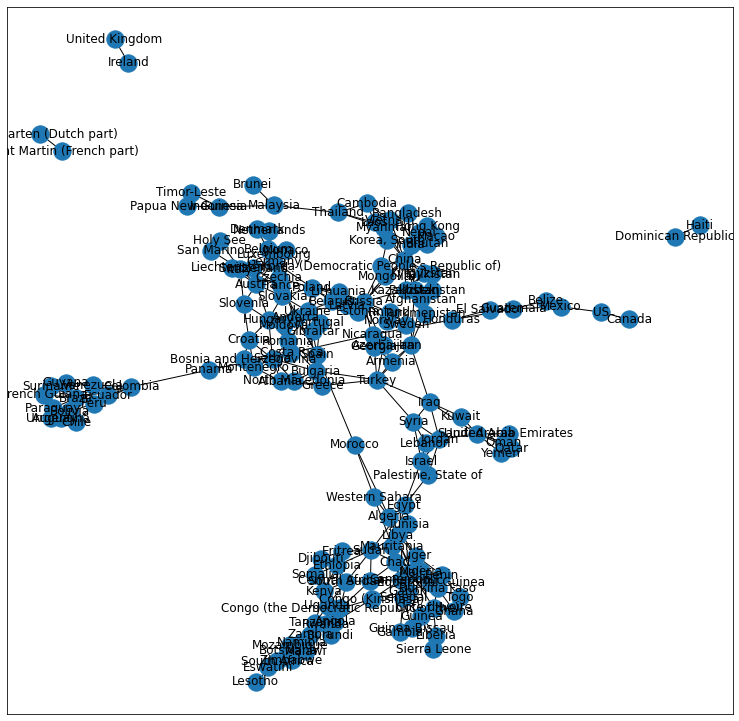

In [28]:
plt.figure(3,figsize=(13,13))
nx.draw_networkx(cities_graph)
# camroll(-180)  
# plt.gca().invert_yaxis()
plt.show()